# Mask R-CNN for Keypoint Detection

Example showing how to do keypoint detection with Mask R-CNN

In [1]:
%matplotlib inline
import importlib
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
import imgaug

# Root directory of the project
ROOT_DIR = os.path.abspath("../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library

from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")

# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

/opt/conda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Load COCO Data for Keypoint Detection

In [2]:
# Import COCO classes
sys.path.append(os.path.join(ROOT_DIR, "samples/coco/"))

import coco_keypoints
importlib.reload(coco_keypoints)

# COCO dataset dir
COCO_DATA_DIR = os.path.join(ROOT_DIR, "data/coco")

# Prepare datasets
dataset_train = coco_keypoints.CocoDataset()
dataset_train.load_coco(COCO_DATA_DIR, subset="train", year="2017", auto_download=True)
dataset_train.prepare()

dataset_val = coco_keypoints.CocoDataset()
dataset_val.load_coco(COCO_DATA_DIR, subset="val", year="2017", auto_download=True)
dataset_val.prepare()

... done downloading.
Unzipping /datasets/home/78/378/cs252cas/Pose_RCNN/data/coco/train2017.zip
... done unzipping
Will use images in /datasets/home/78/378/cs252cas/Pose_RCNN/data/coco/train2017
... done downloading.
Unzipping /datasets/home/78/378/cs252cas/Pose_RCNN/data/coco/annotations_trainval2017.zip
... done unzipping
Will use annotations in /datasets/home/78/378/cs252cas/Pose_RCNN/data/coco/annotations/person_keypoints_train2017.json
loading annotations into memory...
Done (t=8.74s)
creating index...
index created!
... done downloading.
Unzipping /datasets/home/78/378/cs252cas/Pose_RCNN/data/coco/val2017.zip
... done unzipping
Will use images in /datasets/home/78/378/cs252cas/Pose_RCNN/data/coco/val2017
Will use annotations in /datasets/home/78/378/cs252cas/Pose_RCNN/data/coco/annotations/person_keypoints_val2017.json
loading annotations into memory...
Done (t=0.28s)
creating index...
index created!


### List the Keypoint Classes

In [3]:
print("Keypoint classes:")
print(dataset_train.class_names)

Keypoint classes:
['BG', 'nose', 'left_eye', 'right_eye', 'left_ear', 'right_ear', 'left_shoulder', 'right_shoulder', 'left_elbow', 'right_elbow', 'left_wrist', 'right_wrist', 'left_hip', 'right_hip', 'left_knee', 'right_knee', 'left_ankle', 'right_ankle']


### Show Example Image

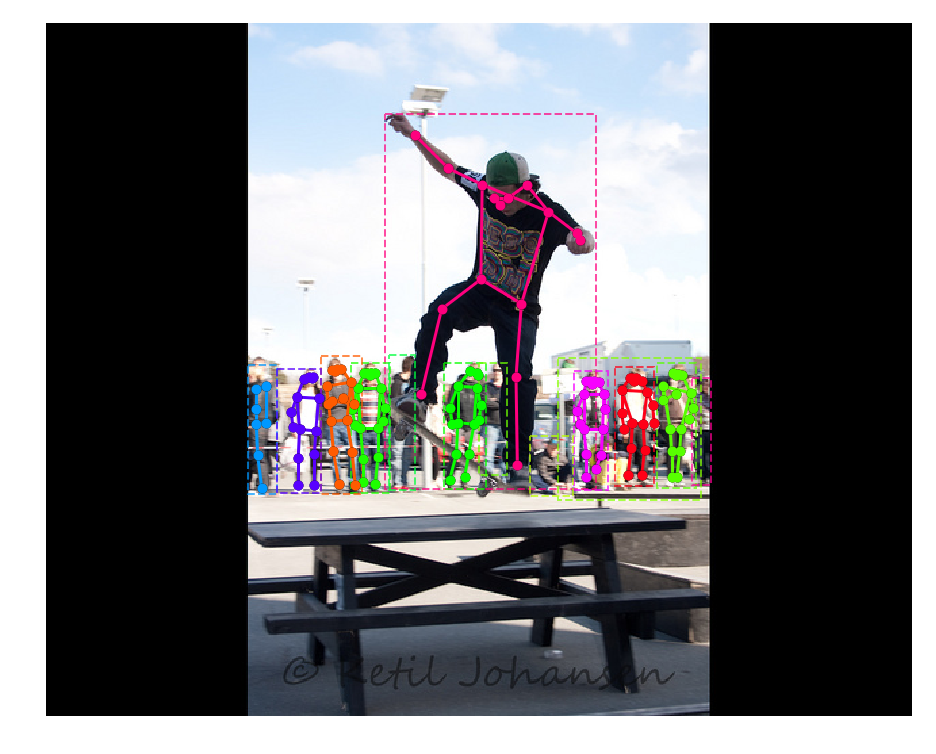

In [4]:
image_id = dataset_train.image_ids[3]
image = dataset_train.load_image(image_id)
masks, class_ids = dataset_train.load_mask(image_id)
bbox = dataset_train.load_bbox(image_id)
importlib.reload(visualize)

visualize.display_keypoints(image, bbox, masks, class_ids, dataset_train.class_names, skeleton=dataset_train.skeleton)

### Setup Training

In [5]:
class TrainConfig(coco_keypoints.CocoConfig):
    NAME = "COCO Keypoints"
    
    # batch size = GPU_COUNT * IMAGES_PER_GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    
    # Use resnet50
    BACKBONE = "resnet50"
    
    # All the keypoints + BG
    NUM_CLASSES = len(dataset_train.class_names) + 1

config = TrainConfig()
config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                31
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES               100
MEAN_PIXEL                     [123.7 116.8 103.9]

In [6]:
# Create model object in inference mode.
model = modellib.MaskRCNN(mode="training", model_dir=MODEL_DIR, config=config)

# Load weights trained on MS-COCO
model.load_weights(COCO_MODEL_PATH, by_name=True,
                   exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", "mrcnn_bbox", "mrcnn_mask"])

In [7]:
# Image Augmentation
# Right/Left flip 50% of the time
augmentation = imgaug.augmenters.Fliplr(0.5)

# Training - Stage 1
print("Training network heads")
model.train(dataset_train, dataset_val,
            learning_rate=config.LEARNING_RATE,
            epochs=1,
            layers="heads",
            augmentation=augmentation)

Training network heads

Starting at epoch 0. LR=0.001

Checkpoint Path: /datasets/home/78/378/cs252cas/Pose_RCNN/logs/coco keypoints20180519T0407/mask_rcnn_coco keypoints_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistri

/opt/conda/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:96: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:1987: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'
ERROR:root:Error processing image {'id': 67749, 'source': 'coco', 'path': '/datasets/home/78/378/cs252cas/Pose_RCNN/data/coco/train2017/000000067749.jpg', 'width': 640, 'height': 427, 'annotations': [{'segmentation': [[93.75, 320.5, 89.21, 330.52, 87.51, 336.38, 90.35, 338.46, 89.4, 340.73, 78.44, 341.29, 76.36, 340.35, 76.73, 336.38, 80.33, 334.87, 83.35, 334.49, 86.57, 326.93, 86.94, 322.77, 80.52, 320.69, 77.87, 31

TypeError: only integer scalar arrays can be converted to a scalar index
ERROR:root:Error processing image {'id': 445250, 'source': 'coco', 'path': '/datasets/home/78/378/cs252cas/Pose_RCNN/data/coco/train2017/000000445250.jpg', 'width': 640, 'height': 427, 'annotations': [{'segmentation': [[503.36, 208.63, 505.47, 198.05, 503.36, 188.87, 508.65, 177.93, 509, 169.82, 510.41, 165.58, 509.35, 161, 511.47, 159.23, 513.94, 160.64, 514.65, 164.88, 515.71, 167, 522.41, 170.88, 525.23, 174.76, 518.53, 184.29, 518.53, 190.99, 517.82, 200.16, 519.23, 212.16, 513.24, 213.93, 511.12, 202.99, 510.41, 190.99, 509.35, 199.46, 508.3, 207.93, 504.77, 212.52, 501.94, 211.46]], 'num_keypoints': 0, 'area': 613.0598, 'iscrowd': 0, 'keypoints': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'image_id': 445250, 'bbox': [501.94, 159.23, 23.29, 54.7], 'category_id': 1, 'id': 453616}, {'segmentation': [[

TypeError: only integer scalar arrays can be converted to a scalar index


ERROR:root:Error processing image {'id': 548844, 'source': 'coco', 'path': '/datasets/home/78/378/cs252cas/Pose_RCNN/data/coco/train2017/000000548844.jpg', 'width': 640, 'height': 426, 'annotations': [{'segmentation': [[330.05, 218.28, 326.22, 210.6, 315.66, 186.61, 309.91, 182.78, 304.15, 174.14, 295.51, 165.51, 293.59, 164.55, 290.72, 155.91, 288.8, 148.24, 284, 135.76, 278.24, 130.97, 276.32, 129.05, 270.57, 123.29, 265.77, 121.37, 256.18, 121.37, 252.34, 121.37, 247.54, 122.33, 242.74, 122.33, 241.78, 121.37, 237.95, 120.41, 236.03, 116.57, 231.23, 114.66, 231.23, 114.66, 221.64, 111.78, 218.76, 113.7, 219.72, 106.02, 219.72, 102.18, 216.84, 98.34, 215.88, 97.39, 214.92, 96.43, 211.08, 93.55, 209.16, 91.63, 206.28, 89.71, 205.32, 87.79, 205.32, 87.79, 193.81, 87.79, 192.85, 87.79, 187.09, 88.75, 184.22, 90.67, 182.3, 92.59, 180.38, 94.51, 174.62, 98.34, 174.62, 99.3, 171.74, 105.06, 169.82, 108.9, 169.82, 10

ValueError: need at least one array to stackERROR:root:Error processing image {'id': 355542, 'source': 'coco', 'path': '/datasets/home/78/378/cs252cas/Pose_RCNN/data/coco/train2017/000000355542.jpg', 'width': 640, 'height': 480, 'annotations': [{'segmentation': [[221.45, 202.93, 243.42, 197.15, 246.88, 182.7, 253.82, 180.39, 259.02, 180.39, 265.38, 190.21, 270.58, 199.46, 279.25, 197.73, 289.08, 196.57, 291.39, 200.62, 288.5, 207.55, 263.07, 216.23, 264.8, 238.19, 265.38, 259, 264.8, 275.19, 241.1, 272.87, 242.26, 263.05, 245.73, 249.17, 248.04, 242.82, 242.84, 232.41, 231.28, 211.02]], 'num_keypoints': 17, 'area': 2595.56275, 'iscrowd': 0, 'keypoints': [254, 195, 2, 256, 193, 2, 253, 193, 2, 258, 193, 2, 250, 193, 2, 260, 204, 2, 246, 203, 2, 271, 204, 2, 237, 207, 2, 282, 202, 2, 225, 204, 2, 259, 228, 2, 250, 228, 2, 258, 248, 2, 255, 247, 2, 256, 264, 2, 251, 263, 2], 'image_id': 355542, 'bbox': [221.45, 180.39, 69.94, 94.8], 'category_id': 1, 'id': 451148}]}
Traceback (most recent

ValueError: need at least one array to stack
ERROR:root:Error processing image {'id': 282251, 'source': 'coco', 'path': '/datasets/home/78/378/cs252cas/Pose_RCNN/data/coco/train2017/000000282251.jpg', 'width': 640, 'height': 530, 'annotations': [{'segmentation': [[9.53, 510.75, 5.96, 490.5, 22.63, 466.68, 58.36, 445.24, 75.03, 445.24, 96.47, 421.42, 142.92, 380.93, 186.99, 370.21, 203.66, 341.62, 216.76, 309.46, 233.44, 278.5, 242.97, 265.4, 245.35, 252.3, 246.54, 239.19, 258.45, 212.99, 267.98, 209.42, 275.12, 146.3, 279.89, 117.71, 307.28, 90.32, 326.34, 77.22, 338.25, 68.88, 329.91, 55.78, 333.48, 24.81, 350.16, 10.52, 373.98, 5.76, 395.42, 21.24, 395.42, 52.21, 387.08, 73.64, 381.12, 85.55, 402.56, 89.13, 415.66, 110.57, 418.04, 137.96, 410.9, 161.78, 422.81, 204.66, 435.91, 243.96, 450.2, 259.44, 453.78, 268.97, 469.26, 271.35, 478.79, 285.64, 429.96, 282.07, 396.61, 223.71, 389.46, 180.84, 371.6, 218.95, 372.79, 241.58, 410.9, 280.88, 433.53, 322.57, 454.97, 352.34, 447.82, 379.7

TypeError: only integer scalar arrays can be converted to a scalar indexERROR:root:Error processing image {'id': 501358, 'source': 'coco', 'path': '/datasets/home/78/378/cs252cas/Pose_RCNN/data/coco/train2017/000000501358.jpg', 'width': 640, 'height': 427, 'annotations': [{'segmentation': [[584.07, 152.7, 584.3, 151.54, 590.35, 153.86, 591.75, 157.82, 591.28, 161.31, 590.82, 163.87, 589.19, 167.83, 588.96, 172.49, 588.26, 172.72, 582.67, 175.28, 585.46, 170.39, 585.46, 166.9, 584.53, 158.99, 583.83, 156.89, 584.77, 154.1]], 'num_keypoints': 0, 'area': 116.84605, 'iscrowd': 0, 'keypoints': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'image_id': 501358, 'bbox': [582.67, 151.54, 9.08, 23.74], 'category_id': 1, 'id': 189003}, {'segmentation': [[564.03, 174.41, 563.83, 172.83, 564.03, 168.09, 563.04, 160.78, 563.44, 155.24, 565.22, 153.66, 567.19, 153.07, 569.56, 153.07, 570.95, 15

TypeError: only integer scalar arrays can be converted to a scalar indexERROR:root:Error processing image {'id': 198761, 'source': 'coco', 'path': '/datasets/home/78/378/cs252cas/Pose_RCNN/data/coco/train2017/000000198761.jpg', 'width': 427, 'height': 640, 'annotations': [{'segmentation': [[109.8, 209.12, 130.02, 212.01, 138.69, 213.45, 156.03, 196.12, 163.25, 181.67, 177.7, 170.11, 186.37, 161.44, 193.59, 151.33, 196.48, 148.44, 202.26, 162.89, 200.81, 175.89, 187.81, 199.01, 174.81, 217.79, 187.81, 238.01, 231.15, 249.57, 223.93, 259.68, 244.15, 292.91, 261.49, 300.14, 296.16, 310.25, 339.5, 324.7, 346.73, 331.92, 351.06, 340.59, 336.61, 356.48, 325.06, 369.48, 297.61, 396.93, 281.72, 415.71, 264.38, 425.82, 247.04, 428.71, 235.49, 414.27, 192.14, 369.48, 180.59, 329.03, 170.47, 297.25, 143.02, 284.24, 115.58, 282.8, 73.68, 255.35, 69.35, 217.79, 93.91, 204.79]], 'num_keypoints': 13, 'area': 26894.6375, 'iscrowd': 0, 'keypoints': [0, 0, 0, 86, 276, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 87, 2

TypeError: only integer scalar arrays can be converted to a scalar indexERROR:root:Error processing image {'id': 407532, 'source': 'coco', 'path': '/datasets/home/78/378/cs252cas/Pose_RCNN/data/coco/train2017/000000407532.jpg', 'width': 640, 'height': 474, 'annotations': [{'segmentation': [[504.62, 336.94, 595.26, 297.75, 586.68, 280.6, 580.56, 273.25, 586.68, 257.33, 585.46, 234.06, 573.21, 212.01, 552.39, 213.23, 534.02, 227.93, 527.89, 248.75, 532.79, 257.33, 532.79, 268.35, 537.69, 276.92, 536.47, 286.72, 524.22, 300.2, 519.32, 311.22, 498.5, 335.72], [449.5, 400.63, 476.45, 333.27, 469.1, 333.27, 462.98, 329.59, 462.98, 313.67, 443.38, 302.65, 423.78, 317.34, 437.26, 332.04, 442.16, 346.74, 434.81, 343.06, 418.88, 333.27, 405.41, 332.04, 396.84, 329.59, 391.94, 335.72, 391.94, 338.16, 394.39, 351.64, 400.51, 361.44, 400.51, 377.36, 401.74, 387.16, 407.86, 403.08, 410.31, 407.98, 416.43, 406.75, 417.66, 393.28, 433.58, 390.83, 448.28, 395.73, 449.5, 395.73]], 'num_keypoints': 11, '

TypeError: only integer scalar arrays can be converted to a scalar index
ERROR:root:Error processing image {'id': 114172, 'source': 'coco', 'path': '/datasets/home/78/378/cs252cas/Pose_RCNN/data/coco/train2017/000000114172.jpg', 'width': 344, 'height': 500, 'annotations': [{'segmentation': [[259.55, 228.09, 277.53, 240.45, 316.85, 243.82, 325.84, 252.81, 338.2, 487.64, 222.47, 487.64, 223.6, 478.65, 189.89, 462.92, 142.7, 417.98, 113.48, 394.38, 162.92, 401.12, 167.42, 384.27, 171.91, 359.55, 192.13, 374.16, 205.62, 410.11, 232.58, 440.45, 244.94, 413.48, 240.45, 394.38, 217.98, 386.52, 206.74, 366.29, 212.36, 346.07, 216.85, 339.33, 183.15, 323.6, 162.92, 322.47, 146.07, 285.39, 146.07, 280.9]], 'num_keypoints': 11, 'area': 36542.52755, 'iscrowd': 0, 'keypoints': [162, 306, 2, 163, 283, 2, 0, 0, 0, 208, 259, 2, 0, 0, 0, 318, 299, 2, 241, 305, 2, 324, 468, 2, 208, 384, 1, 194, 435, 2, 186, 356, 1, 0, 0, 0, 0, 0, 0, 158, 481, 1, 61, 469, 1, 0, 0, 0, 0, 0, 0], 'image_id': 114172, 'bbox':

TypeError: only integer scalar arrays can be converted to a scalar index


ERROR:root:Error processing image {'id': 141207, 'source': 'coco', 'path': '/datasets/home/78/378/cs252cas/Pose_RCNN/data/coco/train2017/000000141207.jpg', 'width': 640, 'height': 427, 'annotations': [{'segmentation': [[482.62, 300.72, 486.62, 305.52, 489.82, 311.12, 493.01, 314.31, 503.01, 309.52, 502.21, 305.12, 497.81, 303.52, 493.81, 298.73, 497.81, 296.33, 501.01, 301.12, 504.61, 300.72, 507.4, 300.33, 510.2, 305.12, 510.2, 308.72, 513.8, 309.12, 513.8, 313.52, 513.8, 313.52, 515, 318.31, 517.4, 330.3, 519.39, 334.3, 519.39, 336.3, 512.2, 338.7, 513, 345.49, 508.6, 344.69, 507.8, 343.09, 507.8, 339.1, 499.41, 339.9, 497.01, 339.9, 496.21, 335.5, 497.41, 333.1, 502.61, 331.1, 504.21, 330.7, 504.21, 325.11, 498.61, 322.71, 499.01, 317.51, 492.21, 316.31, 487.82, 313.92, 483.42, 308.72, 482.22, 306.32, 481.02, 303.12, 479.02, 301.52, 482.22, 299.93, 483.02, 302.32]], 'num_keypoints': 0, 'area': 701.26425, 'isc

TypeError: only integer scalar arrays can be converted to a scalar index



ERROR:root:Error processing image {'id': 174967, 'source': 'coco', 'path': '/datasets/home/78/378/cs252cas/Pose_RCNN/data/coco/train2017/000000174967.jpg', 'width': 426, 'height': 640, 'annotations': [{'segmentation': [[201.35, 297.47, 165.39, 273.02, 201.35, 205.42, 230.11, 196.79, 225.8, 186.73, 218.61, 153.65, 225.8, 130.64, 251.69, 126.32, 277.57, 160.84, 280.45, 185.29, 309.21, 192.48, 343.73, 227, 339.42, 273.02, 313.53, 297.47]], 'num_keypoints': 12, 'area': 18518.9469, 'iscrowd': 0, 'keypoints': [236, 161, 2, 244, 150, 2, 228, 160, 2, 266, 162, 2, 0, 0, 0, 294, 209, 2, 215, 218, 2, 341, 252, 2, 186, 269, 2, 298, 291, 2, 216, 295, 2, 286, 325, 1, 226, 325, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'image_id': 174967, 'bbox': [165.39, 126.32, 178.34, 171.15], 'category_id': 1, 'id': 502629}]}
Traceback (most recent call last):
  File "/datasets/home/78/378/cs252cas/Pose_RCNN/mrcnn/model.py", line 1697, in d

TypeError: only integer scalar arrays can be converted to a scalar indexERROR:root:Error processing image {'id': 576629, 'source': 'coco', 'path': '/datasets/home/78/378/cs252cas/Pose_RCNN/data/coco/train2017/000000576629.jpg', 'width': 427, 'height': 640, 'annotations': [{'segmentation': [[203.7, 456.79, 203.7, 465.46, 215.26, 488.57, 231.98, 547.71, 235.49, 555.6, 237.24, 556.48, 240.75, 560.87, 245.13, 562.62, 249.52, 569.64, 253.9, 578.41, 254.78, 582.79, 254.78, 592.36, 254.78, 595.25, 262.93, 618.69, 251.38, 625.91, 251.38, 630.25, 261.49, 630.25, 291.83, 633.14, 296.16, 628.8, 296.16, 608.58, 291.83, 601.35, 291.83, 581.13, 287.49, 562.35, 287.49, 552.23, 283.16, 533.45, 280.27, 513.23, 271.6, 498.78, 262.93, 467, 258.6, 442.44, 262.93, 414.99, 271.6, 384.65, 277.38, 365.87, 254.27, 303.75, 254.27, 276.3, 254.27, 257.52, 248.49, 237.29, 248.49, 212.73, 248.49, 205.51, 232.6, 198.28, 225.37, 191.06, 239.82, 166.5, 239.82, 131.83, 239.82, 131.83, 229.71, 131.83, 225.37, 126.05, 21

TypeError: only integer scalar arrays can be converted to a scalar index



ERROR:root:Error processing image {'id': 276247, 'source': 'coco', 'path': '/datasets/home/78/378/cs252cas/Pose_RCNN/data/coco/train2017/000000276247.jpg', 'width': 640, 'height': 426, 'annotations': [{'segmentation': [[371.43, 328.36, 364.73, 266.13, 342.71, 307.29, 311.12, 325.48, 294.85, 313.04, 331.23, 254.64, 348.46, 239.33, 376.22, 215.39, 382.92, 203.91, 344.63, 161.78, 333.14, 114.88, 309.21, 95.73, 331.23, 50.74, 358.99, 28.72, 391.54, 31.59, 456.63, 68.93, 448.02, 112.96, 448.02, 144.55, 493.97, 207.73, 508.33, 266.13, 495.88, 314.95, 489.18, 337.93, 490.14, 380.05, 490.14, 404.94, 460.46, 418.34, 385.79, 418.34, 361.86, 420.26, 358.99, 401.11, 276.66, 375.26, 254.64, 375.26, 247.94, 365.69, 257.51, 349.42, 370.48, 347.5]], 'num_keypoints': 12, 'area': 54348.61085, 'iscrowd': 0, 'keypoints': [352, 160, 2, 358, 137, 2, 347, 144, 2, 412, 112, 2, 0, 0, 0, 468, 221, 2, 406, 173, 2, 422, 378, 2, 406, 244, 

TypeError: only integer scalar arrays can be converted to a scalar indexERROR:root:Error processing image {'id': 368125, 'source': 'coco', 'path': '/datasets/home/78/378/cs252cas/Pose_RCNN/data/coco/train2017/000000368125.jpg', 'width': 427, 'height': 640, 'annotations': [{'segmentation': [[182.65, 486.11, 202.79, 488.99, 197.03, 464.54, 201.35, 448.72, 204.22, 440.09, 222.92, 454.47, 232.99, 483.24, 230.11, 494.74, 244.49, 493.3, 247.37, 470.29, 247.37, 455.91, 244.49, 447.28, 254.56, 432.9, 254.56, 414.2, 243.06, 399.82, 243.06, 385.44, 241.62, 372.49, 228.67, 363.87, 228.67, 352.36, 232.99, 335.1, 232.99, 330.79, 224.36, 319.28, 208.54, 319.28, 202.79, 332.22, 202.79, 346.61, 198.47, 359.55, 185.53, 378.25, 176.9, 388.31, 169.71, 392.63, 169.71, 396.94, 175.46, 404.13, 179.78, 404.13, 174.02, 428.58, 181.21, 441.53, 184.09, 457.35, 179.78, 481.8]], 'num_keypoints': 16, 'area': 8406.78395, 'iscrowd': 0, 'keypoints': [210, 347, 2, 217, 344, 2, 206, 342, 2, 227, 348, 2, 0, 0, 0, 231, 3

Epoch 1/1


ERROR:root:Error processing image {'id': 26895, 'source': 'coco', 'path': '/datasets/home/78/378/cs252cas/Pose_RCNN/data/coco/train2017/000000026895.jpg', 'width': 500, 'height': 375, 'annotations': [{'segmentation': [[15.6, 162.89, 9.7, 140.98, 13.91, 134.24, 15.6, 130.03, 21.49, 130.03, 19.81, 137.61, 24.87, 166.26, 18.12, 165.42]], 'num_keypoints': 0, 'area': 317.01065, 'iscrowd': 0, 'keypoints': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'image_id': 26895, 'bbox': [9.7, 130.03, 15.17, 36.23], 'category_id': 1, 'id': 202923}, {'segmentation': [[17.46, 165.84, 16.25, 164.63, 14.8, 160.75, 14.07, 158.57, 13.83, 156.63, 12.85, 154.44, 11.64, 152.02, 10.67, 146.2, 8.73, 144.5, 8.97, 143.53, 9.94, 142.08, 10.67, 140.62, 11.64, 139.41, 12.37, 137.22, 12.37, 135.53, 10.43, 133.1, 9.7, 132.13, 6.79, 131.65, 4.61, 131.65, 3.15, 132.86, 1.94, 135.53, 2.67, 137.71, 2.18, 139.41, 0.49

TypeError: only integer scalar arrays can be converted to a scalar index


ERROR:root:Error processing image {'id': 227741, 'source': 'coco', 'path': '/datasets/home/78/378/cs252cas/Pose_RCNN/data/coco/train2017/000000227741.jpg', 'width': 640, 'height': 427, 'annotations': [{'segmentation': [[371.47, 44.95, 394.45, 57.4, 410.72, 79.42, 415.51, 118.67, 423.17, 170.37, 426.04, 193.35, 414.55, 249.83, 410.72, 282.38, 445.19, 347.49, 470.08, 370.47, 457.64, 386.74, 428.91, 402.06, 406.89, 399.19, 413.6, 389.61, 420.3, 374.3, 419.34, 353.23, 396.36, 316.85, 387.75, 340.79, 379.13, 374.3, 376.26, 383.87, 382, 403.97, 350.41, 414.51, 317.86, 410.68, 330.3, 402.06, 360.94, 362.81, 362.85, 317.81, 366.68, 281.43, 359.02, 278.56, 340.83, 217.28, 349.45, 188.56, 356.15, 169.41, 343.71, 124.41, 325.52, 84.2, 320.73, 71.76, 335.09, 58.35, 326.47, 34.42, 326.47, 13.36, 338.92, 0, 350.41, 1.87, 366.68, 8.57, 369.56, 21.97]], 'num_keypoints': 14, 'area': 26598.33775, 'iscrowd': 0, 'keypoints': [340, 

TypeError: only integer scalar arrays can be converted to a scalar index
ERROR:root:Error processing image {'id': 170101, 'source': 'coco', 'path': '/datasets/home/78/378/cs252cas/Pose_RCNN/data/coco/train2017/000000170101.jpg', 'width': 640, 'height': 425, 'annotations': [{'segmentation': [[141.35, 312.97, 147.08, 271.9, 201.52, 235.61, 261.69, 187.85, 277.92, 187.85, 301.8, 173.53, 317.08, 144.88, 312.3, 87.57, 341.91, 36.96, 380.11, 23.58, 429.78, 36, 449.83, 86.62, 433.6, 160.16, 415.45, 180.21, 445.06, 173.53, 462.25, 193.58, 483.26, 198.36, 489.94, 206.96, 490.9, 221.28, 526.24, 271.9, 544.38, 291.96, 560.62, 293.87, 577.81, 306.28, 575.9, 311.06, 587.36, 321.56, 590.22, 341.62, 578.76, 356.9, 557.75, 397.01, 552.02, 403.7, 554.89, 418.02, 556.8, 418.98, 290.34, 418.02, 264.55, 376.96, 260.73, 335.89, 255, 318.7, 253.09, 341.62, 240.67, 357.85, 232.08, 390.33, 210.11, 401.79, 200.56, 411.34, 205.34, 388.42, 203.43, 325.38, 194.83, 312.97, 164.27, 310.1, 146.12, 312.01]], 'num_key

TypeError: only integer scalar arrays can be converted to a scalar index
ERROR:root:Error processing image {'id': 387255, 'source': 'coco', 'path': '/datasets/home/78/378/cs252cas/Pose_RCNN/data/coco/train2017/000000387255.jpg', 'width': 640, 'height': 360, 'annotations': [{'segmentation': [[68.01, 346.51, 81.78, 341.79, 86.31, 332.93, 87.88, 318.18, 87.68, 293.98, 101.85, 284.15, 116.8, 275.49, 117.78, 270.18, 121.32, 252.67, 119.94, 249.53, 105.78, 242.25, 94.17, 241.26, 72.93, 250.31, 58.96, 254.64, 52.47, 257.4, 43.22, 254.64, 44.4, 249.92, 62.9, 241.66, 81.78, 232.61, 97.32, 218.64, 97.52, 214.9, 96.14, 212.74, 95.16, 209.99, 95.16, 207.63, 95.16, 205.66, 94.76, 203.89, 94.96, 202.31, 93.19, 199.95, 92.01, 196.81, 94.37, 195.04, 101.06, 190.51, 110.11, 189.13, 114.24, 190.91, 120.93, 202.12, 120.53, 210.18, 126.44, 213.53, 129.39, 220.81, 131.75, 223.76, 137.45, 229.66, 132.73, 228.08, 138.04, 233, 140.4, 235.36, 140.4, 238.51, 144.14, 251.49, 146.7, 261.53, 146.7, 274.51, 144.73,

ValueError: need at least one array to stack
ERROR:root:Error processing image {'id': 530901, 'source': 'coco', 'path': '/datasets/home/78/378/cs252cas/Pose_RCNN/data/coco/train2017/000000530901.jpg', 'width': 640, 'height': 427, 'annotations': [{'segmentation': [[17.27, 388.62, 194.79, 324.33, 236.05, 273.47, 246.6, 258.12, 246.6, 223.58, 239.89, 151.61, 256.2, 110.35, 263.88, 87.32, 306.1, 71.97, 332, 72.93, 350.24, 81.56, 376.14, 89.24, 405.89, 126.66, 395.33, 224.53, 394.38, 274.43, 379.02, 306.1, 402.05, 356.95, 460.58, 370.39, 489.37, 397.25, 493.21, 412.61, 6.72, 418.36]], 'num_keypoints': 5, 'area': 70770.3473, 'iscrowd': 0, 'keypoints': [343, 209, 2, 372, 179, 2, 307, 169, 2, 0, 0, 0, 247, 197, 2, 0, 0, 0, 56, 409, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'image_id': 530901, 'bbox': [6.72, 71.97, 486.49, 346.39], 'category_id': 1, 'id': 447609}, {'segmentation': [[442.35, 353.11, 427.96, 352.16, 415.49, 340.64, 413.57, 336.8

TypeError: only integer scalar arrays can be converted to a scalar index
ERROR:root:Error processing image {'id': 97529, 'source': 'coco', 'path': '/datasets/home/78/378/cs252cas/Pose_RCNN/data/coco/train2017/000000097529.jpg', 'width': 480, 'height': 640, 'annotations': [{'segmentation': [[0.69, 240.92, 19.54, 238.22, 31.66, 238.22, 45.13, 245.4, 54.55, 265.6, 55, 280.86, 40.64, 284.45, 17.75, 284.45, 2.49, 282.21]], 'num_keypoints': 0, 'area': 2174.354, 'iscrowd': 0, 'keypoints': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'image_id': 97529, 'bbox': [0.69, 238.22, 54.31, 46.23], 'category_id': 1, 'id': 1726469}]}
Traceback (most recent call last):
  File "/datasets/home/78/378/cs252cas/Pose_RCNN/mrcnn/model.py", line 1697, in data_generator
    use_mini_mask=config.USE_MINI_MASK)
  File "/datasets/home/78/378/cs252cas/Pose_RCNN/mrcnn/model.py", line 1210, in load_image_gt
  

TypeError: only integer scalar arrays can be converted to a scalar index

ERROR:root:Error processing image {'id': 363716, 'source': 'coco', 'path': '/datasets/home/78/378/cs252cas/Pose_RCNN/data/coco/train2017/000000363716.jpg', 'width': 375, 'height': 500, 'annotations': [{'segmentation': [[145.74, 191.65, 145.74, 171.47, 119.96, 170.35, 117.71, 129.99, 145.74, 69.45, 176.01, 66.09, 174.89, 31.33, 191.7, 3.31, 235.43, 3.31, 241.03, 53.76, 243.27, 73.93, 260.09, 88.51, 274.66, 123.26, 276.91, 158.02, 272.42, 169.23, 233.18, 177.07, 205.16, 198.37, 145.74, 192.77]], 'num_keypoints': 13, 'area': 20397.7049, 'iscrowd': 0, 'keypoints': [205, 50, 2, 215, 42, 2, 195, 41, 2, 229, 48, 2, 183, 44, 2, 241, 97, 2, 155, 95, 2, 258, 158, 2, 124, 149, 2, 206, 157, 2, 188, 155, 2, 238, 231, 1, 159, 230, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'image_id': 363716, 'bbox': [117.71, 3.31, 159.2, 195.06], 'category_id': 1, 'id': 432583}]}
Traceback (most recent call last):
  File "/datasets/home/78/378/c

TypeError: only integer scalar arrays can be converted to a scalar index
ERROR:root:Error processing image {'id': 72550, 'source': 'coco', 'path': '/datasets/home/78/378/cs252cas/Pose_RCNN/data/coco/train2017/000000072550.jpg', 'width': 640, 'height': 473, 'annotations': [{'segmentation': [[170.15, 200.15, 173.29, 182.86, 178.01, 164.53, 184.82, 157.72, 185.08, 155.62, 185.87, 150.9, 187.7, 145.66, 191.1, 142.78, 201.85, 145.4, 203.68, 148.55, 206.56, 149.59, 208.92, 149.59, 209.44, 150.12, 209.97, 151.95, 209.44, 155.1, 213.63, 156.41, 217.3, 156.41, 218.61, 156.41, 220.18, 156.41, 223.85, 159.55, 230.14, 165.84, 231.71, 171.34, 231.97, 175.53, 228.57, 178.15, 222.54, 178.94, 228.04, 183.39, 230.92, 193.34, 230.14, 199.37, 227.52, 201.99, 217.04, 204.08, 202.63, 214.3, 195.82, 225.3, 187.96, 240.5, 179.05, 219.54, 176.96, 218.75, 170.93, 218.75, 168.84, 219.02, 165.96, 218.49, 165.96, 216.14, 168.84, 209.59]], 'num_keypoints': 16, 'area': 3611.35125, 'iscrowd': 0, 'keypoints': [194, 1

TypeError: only integer scalar arrays can be converted to a scalar index
ERROR:root:Error processing image {'id': 355168, 'source': 'coco', 'path': '/datasets/home/78/378/cs252cas/Pose_RCNN/data/coco/train2017/000000355168.jpg', 'width': 480, 'height': 640, 'annotations': [{'segmentation': [[231.55, 147.7, 231.55, 164.95, 247.37, 202.35, 247.37, 219.61, 247.37, 235.43, 254.56, 246.93, 268.94, 249.81, 276.13, 261.31, 322.16, 313.09, 330.79, 311.65, 335.1, 328.91, 335.1, 338.98, 340.85, 338.98, 368.18, 386.44, 368.18, 393.63, 378.25, 406.57, 373.93, 418.08, 369.62, 423.83, 376.81, 446.84, 385.44, 489.99, 389.75, 514.44, 385.44, 527.38, 388.31, 544.64, 395.51, 554.71, 394.07, 567.65, 360.99, 567.65, 366.74, 551.83, 363.87, 515.88, 362.43, 487.11, 340.85, 435.34, 333.66, 454.03, 332.22, 484.23, 340.85, 511.56, 345.17, 534.57, 337.98, 541.76, 359.55, 596.41, 348.04, 607.92, 322.16, 607.92, 303.46, 596.41, 313.53, 583.47, 325.03, 582.03, 322.16, 569.09, 319.28, 540.32, 304.9, 501.49, 296.27,

TypeError: only integer scalar arrays can be converted to a scalar index
ERROR:root:Error processing image {'id': 247529, 'source': 'coco', 'path': '/datasets/home/78/378/cs252cas/Pose_RCNN/data/coco/train2017/000000247529.jpg', 'width': 640, 'height': 480, 'annotations': [{'segmentation': [[34.51, 99.31, 35.26, 99.5, 36.38, 106.06, 38.26, 104.94, 39.01, 103.62, 39.38, 103.44, 39.76, 103.25, 43.33, 110, 41.26, 113.94, 45.76, 128.77, 45.76, 134.02, 37.7, 134.96, 38.63, 131.39, 39.38, 130.46, 38.45, 123.14, 38.26, 121.26, 35.26, 119.57, 36.76, 133.27, 28.13, 134.96, 28.69, 132.71, 30.57, 130.46, 27.38, 114.13, 28.88, 111.69, 32.07, 110.19, 32.82, 109.82, 31.32, 108.13, 30.94, 106.63, 29.25, 104.56, 30.75, 101.37, 33.76, 99.31, 34.32, 98.93], [36.76, 83.17, 37.51, 90.49, 37.7, 92.55, 37.7, 93.12, 37.13, 93.68, 36.19, 94.43, 35.26, 93.68, 34.88, 92.37, 33.94, 91.24, 33.76, 88.05, 33.76, 86.17, 34.32, 85.05]], 'num_keypoints': 0, 'area': 438.50665, 'iscrowd': 0, 'keypoints': [0, 0, 0, 0, 0,

TypeError: only integer scalar arrays can be converted to a scalar index
ERROR:root:Error processing image {'id': 144322, 'source': 'coco', 'path': '/datasets/home/78/378/cs252cas/Pose_RCNN/data/coco/train2017/000000144322.jpg', 'width': 640, 'height': 479, 'annotations': [{'segmentation': [[640, 258.01, 598.27, 233.04, 569.85, 219.26, 545.74, 205.49, 536.26, 205.49, 519.04, 200.32, 503.54, 189.12, 512.15, 160.71, 494.07, 142.62, 487.18, 140.9, 449.29, 59.96, 423.46, 26.37, 397.62, 2.26, 198.7, 0.54, 179.76, 26.37, 165.98, 35.84, 156.51, 58.23, 152.2, 71.15, 150.48, 90.1, 147.04, 102.15, 152.2, 121.96, 159.09, 143.48, 165.12, 157.26, 174.59, 170.18, 180.62, 199.46, 178.04, 219.26, 179.76, 231.32, 187.51, 237.35, 205.59, 251.13, 205.59, 280.4, 221.09, 307.1, 233.15, 315.71, 254.68, 324.32, 270.18, 338.96, 294.29, 352.74, 303.76, 363.07, 317.54, 382.02, 324.43, 386.32, 351.12, 395.79, 364.9, 393.21, 355.43, 406.13, 345.96, 423.35, 341.65, 431.96, 339.07, 446.6, 335.62, 462.96, 333.9, 479

TypeError: only integer scalar arrays can be converted to a scalar indexERROR:root:Error processing image {'id': 25293, 'source': 'coco', 'path': '/datasets/home/78/378/cs252cas/Pose_RCNN/data/coco/train2017/000000025293.jpg', 'width': 400, 'height': 515, 'annotations': [{'segmentation': [[118.04, 45.13, 124.99, 57.87, 129.62, 69.44, 133.09, 81.01, 156.24, 121.52, 156.24, 121.52, 194.43, 93.74, 231.46, 91.43, 246.51, 100.69, 255.76, 112.26, 258.08, 136.56, 256.92, 158.55, 267.34, 192.11, 329.83, 282.38, 343.72, 297.43, 376.12, 344.88, 381.91, 380.75, 387.7, 447.88, 396.96, 486.07, 399.27, 498.8, 400, 508.06, 329.83, 506.9, 261.55, 510.37, 166.65, 504.58, 162.02, 491.85, 188.64, 431.67, 189.8, 380.75, 164.34, 288.17, 149.29, 248.82, 149.29, 234.93, 69.44, 226.83, 32.4, 162.02, 17.36, 129.62, 13.89, 109.94, 13.89, 100.69, 13.89, 96.06, 32.4, 96.06, 33.56, 96.06, 49.76, 130.78, 67.12, 178.22, 90.27, 193.27, 143.51, 195.58, 170.12, 195.58, 175.91, 193.27, 158.55, 156.24, 151.61, 145.82, 13

Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2910, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-7-2ca0054c9a0c>", line 11, in <module>
    augmentation=augmentation)
  File "/datasets/home/78/378/cs252cas/Pose_RCNN/mrcnn/model.py", line 2330, in train
    use_multiprocessing=True,
  File "/opt/conda/lib/python3.6/site-packages/keras/legacy/interfaces.py", line 87, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.6/site-packages/keras/engine/training.py", line 2011, in fit_generator
    generator_output = next(output_generator)
StopIteration

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 1828, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'StopIteration' object has no attribut

StopIteration: 